# Handling unbalanced dataset
Two methods that are worth trying :
1. Generating new data using machine translations
2. Adjusting the threshold

I will focus on generating new data using machine translations here.

# Prepare the spam emails to be fed into machine translator


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf # conda install -c conda-forge tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
url = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/SMSSpamCollection" #Use the RAW one
messages = pd.read_csv(url, sep ='\t', names=["label", "message"])

In [4]:
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [15]:
spam_msg = messages[messages.label=='spam']
spam_msg = spam_msg.drop(labels='label', axis=1)

In [16]:
print(type(spam_msg))
spam_msg

<class 'pandas.core.frame.DataFrame'>


,message
2,Free entry in 2 a wkly comp to win FA Cup fina...
5,FreeMsg Hey there darling it's been 3 week's n...
8,WINNER!! As a valued network customer you have...
9,Had your mobile 11 months or more? U R entitle...
11,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...
5537,Want explicit SEX in 30 secs? Ring 02073162414...
5540,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,Had your contract mobile 11 Mnths? Latest Moto...
5566,REMINDER FROM O2: To get 2.50 pounds free call...


In [19]:
spam_msg.to_csv('spam.csv', index=False) #Then convert to .xlsx for the website

# Using a machine translator
https://www.onlinedoctranslator.com/fr/

I used 6 languages : Danish, German, Dutch, Spanish, French and Finnish.
Then I copy-pasted the text in the .xlsx file into a blank file.
With the addition of the normal dataset, we have 7*747=5229 spam messages and 4825 ham messages.

In [15]:
url2 = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/Spam"
new_spam = pd.read_csv(url2, sep ='\t', names=["message"]) # No label like the usual file here

In [16]:
spam_labels = ["spam" for i in range(len(new_spam))]
new_spam.insert(0, "label", spam_labels, allow_duplicates=True) # Making the datasets have the same format
new_spam

,label,message
0,spam,Free admission to 2 a weekly tournament to win...
1,spam,FreeMsg Hi darling it's been 3 weeks now and n...
2,spam,"WINNER!! As a valued network customer, you hav..."
3,spam,Have you had your mobile for 11 months or more...
4,spam,"Six chances to win CASH! From 100 to 20,000 po..."
...,...,...
4477,spam,Want explicit SEX in 30 seconds? Call 02073162...
4478,spam,WANTED 3MOBILE IF 0870 CHATLINES INCLUDING FRE...
4479,spam,Did you have an 11 Months mobile subscription?...
4480,spam,O2 REMINDER: To get £2.50 free credit and deta...


In [20]:
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
print(len(ham_msg), len(spam_msg) + len(new_spam))

4825 5229


In [22]:
new_spam_df = new_spam.sample(n = len(ham_msg) - len(spam_msg), random_state = 754)
print(ham_msg.shape, spam_msg.shape, new_spam_df.shape)

(4825, 2) (747, 2) (4078, 2)


In [23]:
msg_df = pd.concat([ham_msg, spam_msg, new_spam_df])
msg_df.reset_index(drop=True)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,ham,Even my brother is not like to speak with me. ...
...,...,...
9645,spam,You have a secret admirer who is looking 2 con...
9646,spam,25p 4 Alfie Moon's Children in need song on ur...
9647,spam,Block Breaker now comes in deluxe format with ...
9648,spam,"Sun vacation. To claim your medical holiday, s..."


In [26]:
msg_labels = (msg_df['label'].map({'ham': 0, 'spam': 1})).values

In [31]:
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'],
                                                                  msg_labels,
                                                                  test_size=0.2,
                                                                  random_state=705)

In [34]:
#Tokenizer : turn words into integers
oov_tok = "<OOV>" # What to replace words that are not in the vocabulary with
vocab_size = 500 # Maximum number of words for tokenizer

tokenizer = Tokenizer(num_words = vocab_size,
                      char_level=False, # Work words by word
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [35]:
# Sequencing and padding on training and testing 
max_len = 50 # Max number of tokens, used with truncating and padding
trunc_type = "post" # Truncates sequences of tokens that are longer than max_len, post=right side
padding_type = "post" # Pads AFTER (with post) if sequence is shorter than max_len

training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                               padding = padding_type, truncating = trunc_type)

In [36]:
X_train = torch.from_numpy(training_padded).float()
X_test = torch.from_numpy(testing_padded).float()
Y_train = torch.from_numpy(train_labels).float()
Y_test = torch.from_numpy(test_labels).float()

In [40]:
iters = 128

net = nn.Sequential(
    nn.Linear(max_len, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=.01)

loss_history = [] #Per epoch
accuracy_history = []
accuracy_test_history = []
sensitivity_history = [] # True positive rate
specificity_history = [] # True negative rate

for i in range(iters):
    proba_pred = net(X_train)  # forward pass
    proba_pred = proba_pred.squeeze(-1)  # transform the 1-element vectors into scalars

    optimizer.zero_grad() # reset the gradients to 0
    loss = criterion(proba_pred, Y_train)
    loss_history.append(loss.item()) # .item() to turn it into a python number
    loss.backward()  # obtain the gradients with respect to the loss
    optimizer.step()  # perform one step of gradient descent

    with torch.no_grad():
        Y_pred = proba_pred > 0.5  # Binary label
        accuracy = (Y_train == Y_pred).float().mean()
        accuracy_history.append(accuracy.item())
            
    with torch.no_grad():
        proba_pred_test = net(X_test)
        proba_pred_test = proba_pred_test.squeeze(-1)
        Y_pred_test = proba_pred_test > 0.5
        
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_test).ravel()
        accuracy_test_history.append((tn+tp)/(tn+fp+fn+tp))
        sensitivity_history.append(tp/(tp+fn))
        specificity_history.append(tn/(tn+fp))
    
    print("Iteration {iter} done".format(iter=i+1))
    print("Training accuracy is equal to {trainAcc}".format(trainAcc=accuracy_history[-1]))
    print("Test accuracy is equal to {t}".format(t=accuracy_test_history[-1]))
    print("Sensitivity is equal to {t}".format(t=sensitivity_history[-1]))
    print("Specificity is equal to {t}".format(t=specificity_history[-1]))

Iteration 1 done
Training accuracy is equal to 0.576036274433136
Test accuracy is equal to 0.6668393782383419
Sensitivity is equal to 0.7014462809917356
Specificity is equal to 0.632016632016632
Iteration 2 done
Training accuracy is equal to 0.6575129628181458
Test accuracy is equal to 0.7036269430051814
Sensitivity is equal to 0.7789256198347108
Specificity is equal to 0.6278586278586279
Iteration 3 done
Training accuracy is equal to 0.7089378237724304
Test accuracy is equal to 0.7036269430051814
Sensitivity is equal to 0.6177685950413223
Specificity is equal to 0.7900207900207901
Iteration 4 done
Training accuracy is equal to 0.6926165819168091
Test accuracy is equal to 0.7518134715025907
Sensitivity is equal to 0.8615702479338843
Specificity is equal to 0.6413721413721414
Iteration 5 done
Training accuracy is equal to 0.7546632289886475
Test accuracy is equal to 0.7766839378238342
Sensitivity is equal to 0.856404958677686
Specificity is equal to 0.6964656964656964
Iteration 6 done
T

Iteration 50 done
Training accuracy is equal to 0.848963737487793
Test accuracy is equal to 0.8259067357512954
Sensitivity is equal to 0.856404958677686
Specificity is equal to 0.7952182952182952
Iteration 51 done
Training accuracy is equal to 0.8502590656280518
Test accuracy is equal to 0.827461139896373
Sensitivity is equal to 0.856404958677686
Specificity is equal to 0.7983367983367984
Iteration 52 done
Training accuracy is equal to 0.8511658310890198
Test accuracy is equal to 0.8284974093264249
Sensitivity is equal to 0.8584710743801653
Specificity is equal to 0.7983367983367984
Iteration 53 done
Training accuracy is equal to 0.8516839146614075
Test accuracy is equal to 0.8284974093264249
Sensitivity is equal to 0.8574380165289256
Specificity is equal to 0.7993762993762994
Iteration 54 done
Training accuracy is equal to 0.8524611592292786
Test accuracy is equal to 0.827979274611399
Sensitivity is equal to 0.8543388429752066
Specificity is equal to 0.8014553014553014
Iteration 55 do

Iteration 95 done
Training accuracy is equal to 0.8920984268188477
Test accuracy is equal to 0.8269430051813471
Sensitivity is equal to 0.8512396694214877
Specificity is equal to 0.8024948024948025
Iteration 96 done
Training accuracy is equal to 0.8895077705383301
Test accuracy is equal to 0.822279792746114
Sensitivity is equal to 0.8119834710743802
Specificity is equal to 0.8326403326403327
Iteration 97 done
Training accuracy is equal to 0.8930051922798157
Test accuracy is equal to 0.827979274611399
Sensitivity is equal to 0.875
Specificity is equal to 0.7806652806652806
Iteration 98 done
Training accuracy is equal to 0.879145085811615
Test accuracy is equal to 0.8145077720207254
Sensitivity is equal to 0.7758264462809917
Specificity is equal to 0.8534303534303534
Iteration 99 done
Training accuracy is equal to 0.8862694501876831
Test accuracy is equal to 0.8290155440414507
Sensitivity is equal to 0.8450413223140496
Specificity is equal to 0.8128898128898129
Iteration 100 done
Trainin

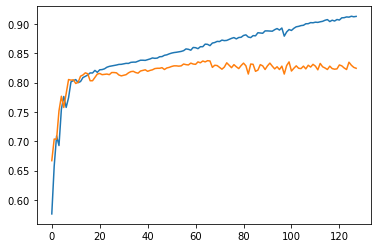

In [41]:
plt.plot(accuracy_history)
plt.plot(accuracy_test_history)

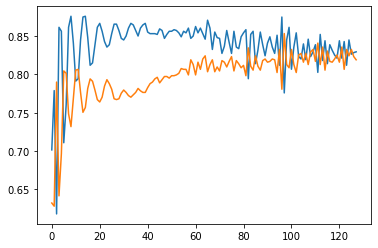

In [42]:
plt.plot(sensitivity_history)
plt.plot(specificity_history)

In [43]:
print(accuracy_test_history[-1], sensitivity_history[-1], specificity_history[-1]) #We get better results indeed

0.8243523316062176 0.8295454545454546 0.8191268191268192
